# define the state q by x, y, vx, vy
real transformation:
$ q_t = A_tq_{t-1} + B_ta_{t-1} $

In [615]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from copy import deepcopy

In [616]:
def plot_throwing(q, o = None, q_preds = None):
    x = q[:,0]
    y = q[:,1]
    vx = q[:,2]
    vy = q[:,3]
    plt.plot(x, y, '-', color='g')
    # plt.quiver(x, y, vx, np.zeros_like(vx), angles='xy', scale_units='xy', scale=2, color='g', label='Velocity vectors')
    # plt.quiver(x, y, np.zeros_like(vy), vy, angles='xy', scale_units='xy', scale=2, color='y', label='Velocity vectors')
    # plt.legend()
    plt.xlim(-10, 110)
    plt.ylim(-10, 110)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Trajectory of the object')
    plt.grid()
    plt.axis('equal')

    if o is not None:
        ox = o[:, 0]
        oy = o[:, 1]
        plt.scatter(ox, oy, s=4, color='r')
    
    if q_preds is not None:
        xp = q_preds[:,0]
        yp = q_preds[:,1]
        plt.plot(xp, yp, 'o--', color='b')

    plt.show()

In [617]:


delta_t = 1
A = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    (0, 0, 0, 1)
], dtype=float)

B = np.array([
    [0, 0, 0],
    [0, 0.5*delta_t*delta_t, 0],
    [0, 0, 0],
    [0, delta_t, 0]
], dtype=float)

g = 10

action = np.array([0, -g, 0]).reshape((3,1))

# Simulate Observation, Adding normal distributed noise


In [618]:
def random_cov(dim):
    L = np.tri(np.random(dim, dim))
    cov = L@L.T
    return cov

def build_cov(var:list[float]):
    dim = len(var)
    cov = np.eye(dim)
    np.fill_diagonal(cov, var)
    return cov

cov = build_cov([0.1,0.1])
print(cov)

[[0.1 0. ]
 [0.  0.1]]


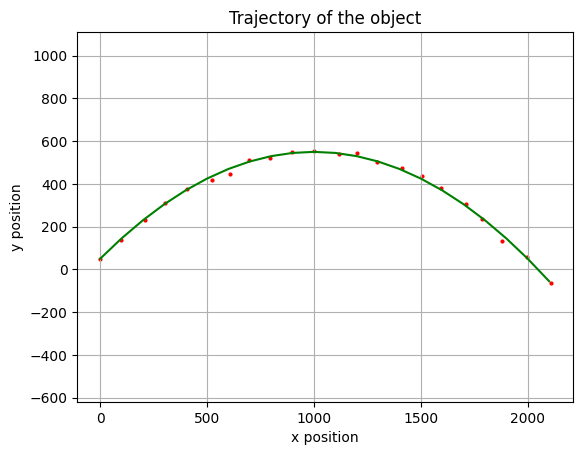

In [619]:
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]]
)
R = build_cov([100, 100])


def simulate_observe(q): 
    return C@q + np.random.multivariate_normal([0,0], R).reshape((2,1))

q0 = np.array([0, 50, 100, 100], dtype=float).reshape((4,1))
q_list = [q0]
o_list = [simulate_observe(q0)]
for t in range(1, 30):
    q0 = A @ q0 + B @ action
    q_list.append(q0)
    o = simulate_observe(q0)
    # print(o)
    o_list.append(o)
    if q0[1] < 0:
        break
plot_throwing(np.array(q_list), np.array(o_list))

[array([[42.85945993],
       [79.02981571],
       [89.78917024],
       [70.51216734]])]


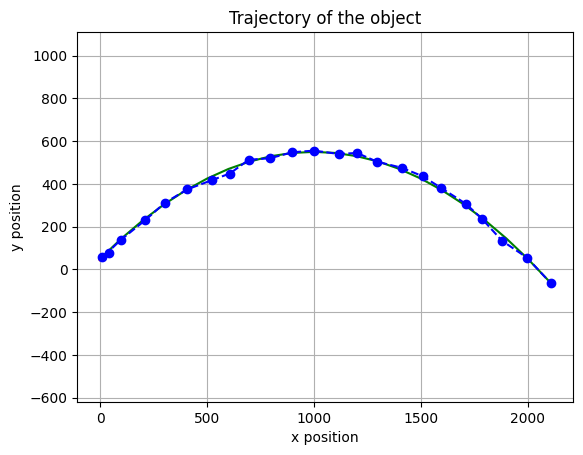

[array([[70.88456078],
       [69.74416381],
       [88.43696978],
       [37.27779197]])]


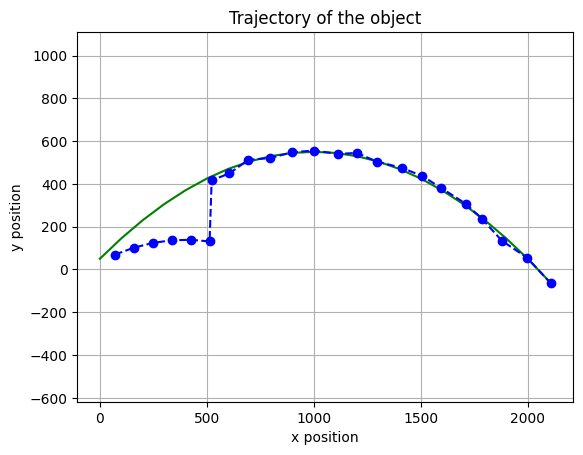

In [620]:
class KalmanFilter:
    def __init__(self):
        self.mu = np.random.random((4,1))*100
        self.sigma = np.eye(4, dtype=float)

        self.action = action # constant for ball throwing
        self.Q = build_cov([1000, 1000, 2000, 2000]) # constant for ball throwing
        self.R = R
        self.C = C

        self.q_preds = [self.mu]
        print(self.q_preds)
        self.sgm_preds = [self.sigma]
    
    def update(self, observe=None):
        # o = np.array(observe).reshape((2,1))
        # prediction
        mu_ = A@self.mu + B@action
        sigma_ = A@self.sigma@A.T + self.Q
        if observe is None:
            self.mu = mu_
            self.sigma = sigma_
        else:
            # update
            K = sigma_@self.C.T@np.linalg.inv(self.C@sigma_@self.C.T + self.R)
            self.mu = mu_ + K@(observe - self.C@mu_)
            self.sigma = (np.eye(4) - K@self.C)@sigma_

        self.q_preds.append(self.mu)
        self.sgm_preds.append(self.sigma)

kf = KalmanFilter()

for o in o_list:
    kf.update(o)

plot_throwing(np.array(q_list), np.array(o_list), np.array(kf.q_preds))

# o_list[0:5] = [np.ones(shape=(2,1),dtype=float)*100]*5
o_list[0:5] = [None]*5

kf1 = KalmanFilter()
for o in o_list:
    kf1.update(o)
plot_throwing(np.array(q_list), np.array([o for o in o_list if o is not None]), np.array(kf1.q_preds))
